In [26]:
import numpy as np
import time
import pickle as pk
from numba import cuda
import json
import matplotlib.pyplot as plt
from fvm_animation import animate_1D_evolution

# Gerênciando propriedades constantes

In [27]:
Db = 5e-5
Dn = 5e-5
phi = 0.2
cb = 0.15
lambd_nb = 1.8
mi_n = 0.2
lambd_bn = 0.1
y_n = 0.1
Cn_max = 0.55e2
X_nb = 1e-2
central_ini_cond = 0.4

# Serializing json
constant_properties = json.dumps(
    {
        "Db": Db,
        "Dn": Dn,
        "phi": phi,
        "cb": cb,
        "lambd_nb": lambd_nb,
        "mi_n": mi_n,
        "lambd_bn": lambd_bn,
        "y_n": y_n,
        "Cn_max": Cn_max,
        "X_nb": X_nb,
        "central_ini_cond": central_ini_cond,
    },
    indent=4,
)

# Writing to sample.json
with open("control_dicts/constant_properties.json", "w") as outfile:
    outfile.write(constant_properties)

# Opening JSON file
with open("control_dicts/constant_properties.json", "r") as openfile:
    # Reading from json file
    constant_properties = json.load(openfile)

Db = constant_properties["Db"]
Dn = constant_properties["Dn"]
phi = constant_properties["phi"]
cb = constant_properties["cb"]
lambd_nb = constant_properties["lambd_nb"]
mi_n = constant_properties["mi_n"]
lambd_bn = constant_properties["lambd_bn"]
y_n = constant_properties["y_n"]
Cn_max = constant_properties["Cn_max"]
X_nb = constant_properties["X_nb"]
central_ini_cond = constant_properties["central_ini_cond"]

# Gerenciando propriedades de malha

In [28]:
h = 0.01
k = 0.005
x_dom = (0, 1)
y_dom = (0, h)
t_dom = (0, 5)

# Serializing json
mesh_properties = json.dumps(
    {
        "h": h,
        "k": k,
        "x_dom": x_dom,
        "y_dom": y_dom,
        "t_dom": t_dom,
    },
    indent=4,
)

# Writing to sample.json
with open("control_dicts/mesh_properties.json", "w") as outfile:
    outfile.write(mesh_properties)

# Opening JSON file
with open("control_dicts/mesh_properties.json", "r") as openfile:
    # Reading from json file
    mesh_properties = json.load(openfile)

h = mesh_properties["h"]
k = mesh_properties["k"]
x_dom = mesh_properties["x_dom"]
y_dom = mesh_properties["y_dom"]
t_dom = mesh_properties["t_dom"]

# Inicializando variáveis

In [ ]:
def preencher_matriz_uniforme(x_size, y_size):
    # Cria uma matriz de zeros com as dimensões fornecidas
    matriz = np.ones((x_size, y_size), dtype=int)

    return matriz


def preencher_matriz_radialmente(x_size, y_size):
    # Cria uma matriz de zeros com as dimensões fornecidas
    matriz = np.zeros((x_size, y_size), dtype=int)

    radius = 3
    cx, cy = (x_size // 2, y_size // 2)

    for i in range(x_size):
        for j in range(y_size):
            # Calculate distance from center to each point
            if (i - cx) ** 2 + (j - cy) ** 2 <= radius**2:
                matriz[i, j] = 1  # Set point inside the circle to 1

    return matriz


def preencher_matriz_randomicamente(x_size, y_size):

    # Cria uma matriz de zeros com as dimensões fornecidas
    matriz = np.zeros((x_size, y_size), dtype=int)

    # Calcula o número total de elementos a serem preenchidos com 1
    total_elementos = x_size * y_size  # <-- FIXED this. Was x_size * x_size

    elementos_para_preencher = int(0.2 * total_elementos)

    # Gera índices aleatórios únicos para preenchimento
    np.random.seed(42)
    indices = np.random.choice(total_elementos, elementos_para_preencher, replace=False)

    # Converte os índices lineares em índices matriciais
    for index in indices:
        i, j = divmod(index, y_size)
        matriz[i, j] = 1

    return matriz


def init_mesh(
    x_dom,
    y_dom,
    t_dom,
    h,
    k,
    center,
    radius,
    create_source=False,
    source_type="central",
    verbose=False,
):
    struct_name = (
        "h--"
        + str(h)
        + "__k--"
        + str(k)
        + "__x_dom_min--"
        + str(x_dom[0])
        + "__x_dom_max--"
        + str(x_dom[-1])
        + "__y_dom_min--"
        + "__t_dom_min--"
        + str(t_dom[0])
        + "__t_dom_max--"
        + str(t_dom[-1])
        + "__center--"
        + str(center)
        + "__radius--"
        + str(radius)
    )

    print("struct_name: ", struct_name)

    size_x = int(((x_dom[1] - x_dom[0]) / (h)))
    size_y = int(((y_dom[1] - y_dom[0]) / (h)))
    size_t = int(((t_dom[1] - t_dom[0]) / (k)) + 1)

    if create_source:
        if source_type == "central":
            leu_source_points = preencher_matriz_radialmente(size_x, size_y)
        elif source_type == "random":
            leu_source_points = preencher_matriz_randomicamente(size_x, size_y)
        elif source_type == "uniform":
            leu_source_points = preencher_matriz_uniforme(size_x, size_y)
        else:
            print("Not implemented type")
            return

        with open("source_points/lymph_vessels.pkl", "wb") as f:
            pk.dump(leu_source_points, f)

    else:
        with open("source_points/lymph_vessels.pkl", "rb") as f:
            leu_source_points = pk.load(f)

    print("Size x = {:d}, y = {:d} \n ".format(size_x, size_y))

    print(
        "Steps in time = {:d}\nSteps in space_x = {:d}\nSteps in space_y = {:d}\n".format(
            size_t,
            size_x,
            size_y,
        )
    )

    return (size_x, size_y, size_t, leu_source_points, struct_name)

# Plot function



In [17]:
def plot_results(size_t, size_x, t_dom, x_dom, Cb, Cn, leu_source_points):

    t_np = np.linspace(t_dom[0], t_dom[-1], num=size_t, endpoint=True, dtype=np.float32)
    x_np = np.linspace(x_dom[0], x_dom[-1], num=size_x, endpoint=False, dtype=np.float32)

    # t_np, x_np, Cb, Cn, source_index already defined
    # source_index is assumed to be an array of x positions only (1D or Nx1)

    time_plot = np.linspace(0, size_t - 1, num=6, endpoint=True, dtype=int)

    fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

    fig.suptitle(
        "$\\bf{Resposta\\ Imunológica}$ — Evolução em 1D", fontsize=18, weight="bold"
    )

    colors = plt.cm.viridis(np.linspace(0, 1, len(time_plot)))

    source_index = np.argwhere(leu_source_points[:, 0] == 1).ravel()

    # Plot Cb
    for i, time_inst in enumerate(time_plot):
        axes[0].plot(
            x_np,
            Cb[time_inst].squeeze(),
            label=f"t = {t_np[time_inst]:.2f}",
            color=colors[i],
            linewidth=2,
            alpha=0.85,
        )

    axes[0].scatter(
        x_np[source_index],  # assuming source_index is Nx2 still
        np.zeros(source_index.shape),  # put the markers at the top for visibility
        color="red",
        label="Fontes",
        s=40,
        marker="x",
    )

    axes[0].set_title("$C_p$ ao longo de x", fontsize=14)
    axes[0].set_ylabel("$C_p$", fontsize=12)
    axes[0].legend()
    axes[0].grid(True, linestyle="--", alpha=0.5)

    # Plot Cn
    for i, time_inst in enumerate(time_plot):
        axes[1].plot(
            x_np,
            Cn[time_inst].squeeze(),
            label=f"t = {t_np[time_inst]:.2f}",
            color=colors[i],
            linewidth=2,
            alpha=0.85,
        )

    axes[1].scatter(
        x_np[source_index],
        np.zeros((len(source_index))),
        color="red",
        label="Fontes",
        s=40,
        marker="x",
    )

    axes[1].set_title("$C_n$ ao longo de x", fontsize=14)
    axes[1].set_xlabel("x", fontsize=12)
    axes[1].set_ylabel("$C_n$", fontsize=12)
    axes[1].legend()
    axes[1].grid(True, linestyle="--", alpha=0.5)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Versão Serial

## Definiçao da função

In [18]:
# Função que descreve a taxa de variação da concentração de bactérias (Cb)
def fb(Cb, Cn, i, j, cb, lambd_nb):
    # O crescimento de bactérias é reduzido pela presença de neutrófilos (Cn)
    # por um fator lambd_nb
    return (cb - lambd_nb * Cn[i, j]) * Cb[i, j]


# Função que descreve a taxa de variação da concentração de neutrófilos (Cn)
def fn(Cb, Cn, source_points, i, j, y_n, Cn_max, lambd_bn, mi_n):
    # Crescimento dos neutrófilos depende da presença de bactérias (Cb)
    # Também considera uma taxa de decaimento natural (mi_n) e a interação com
    # bactérias (lambd_bn)
    return (
        y_n * Cb[i, j] * (Cn_max - Cn[i, j]) * source_points[i, j]
        - lambd_bn * Cn[i, j] * Cb[i, j]
        - mi_n * Cn[i, j]
    )


# Função para aplicar condições iniciais à concentração de bactérias (Cb)
def apply_initial_conditions(ini_cond, Cb, cx, cy, radius, size_x, size_y):
    for i in range(size_x):
        for j in range(size_y):
            # Calculate distance from center to each point
            if (i - cx) ** 2 + (j - cy) ** 2 <= radius**2:
                Cb[i][j] = ini_cond  # Set point inside the circle to 1

    return Cb


# Função principal para resolver as equações diferenciais parciais usando diferenças finitas
def solve_pde(
    leu_source_points,
    size_t,
    size_x,
    size_y,
    h,
    k,
    Db,
    Dn,
    phi,
    cb,
    lambd_nb,
    mi_n,
    lambd_bn,
    y_n,
    Cn_max,
    X_nb,
    initial_cond,
    center,
    radius,
    verbose=False,
):

    # Inicializando as matrizes para concentrações de neutrófilos (Cn) e bactérias (Cb)
    Cn_new = np.zeros((size_x, size_y))
    Cb_new = np.zeros((size_x, size_y))

    # Matrizes para armazenar as concentrações em cada passo de tempo
    Cn_final = np.zeros((size_t, size_x, size_y))
    Cb_final = np.zeros((size_t, size_x, size_y))

    # Aplicando condições iniciais para a concentração de bactérias
    cx_real, cy_real = center
    cx_disc = cx_real / h
    cy_disc = cy_real / h
    radius_disc = radius / h

    Cb_new = apply_initial_conditions(
        initial_cond, Cb_new, cx_disc, cy_disc, radius_disc, size_x, size_y
    )

    # Armazenando as condições iniciais
    Cb_final[0] = Cb_new
    Cn_final[0] = Cn_new

    # Loop sobre o tempo
    for time in range(1, size_t):
        # Atualizando as concentrações anteriores (passo temporal anterior)
        Cn_old = Cn_new.copy()
        Cb_old = Cb_new.copy()

        global_max_v = 0

        # Loop sobre o espaço (malha espacial)
        for i in range(size_x):

            for j in range(size_y):

                diff_Cb_right = (
                    0 if (i == size_x - 1) else (Cb_old[i + 1, j] - Cb_old[i, j])
                )

                diff_Cb_left = 0 if (i == 0) else (Cb_old[i, j] - Cb_old[i - 1, j])

                diff_Cb_up = (
                    0 if (j == size_y - 1) else (Cb_old[i, j + 1] - Cb_old[i, j])
                )

                diff_Cb_down = 0 if (j == 0) else (Cb_old[i, j] - Cb_old[i, j - 1])

                max_vx = np.max(
                    (
                        abs(diff_Cb_left * X_nb / h),
                        abs(diff_Cb_right * X_nb / h),
                    )
                )

                max_vy = np.max(
                    (
                        abs(diff_Cb_down * X_nb / h),
                        abs(diff_Cb_up * X_nb / h),
                    )
                )

                max_v = max(max_vx, max_vy)

                if max_v > global_max_v:
                    global_max_v = max_v

                # Atualizando as concentrações de bactérias
                Cb_new[i][j] = (
                    (k * Db)
                    / (h * h * phi)
                    * (diff_Cb_right - diff_Cb_left + diff_Cb_up - diff_Cb_down)
                    + (k / phi) * fb(Cb_old, Cn_old, i, j, cb, lambd_nb)
                    + Cb_old[i, j]
                )

                diff_Cn_right = (
                    0 if i == size_x - 1 else ((Cn_old[i + 1, j] - Cn_old[i, j]))
                )

                diff_Cn_left = 0 if i == 0 else ((Cn_old[i, j] - Cn_old[i - 1, j]))

                diff_Cn_up = (
                    0 if j == size_y - 1 else ((Cn_old[i, j + 1] - Cn_old[i, j]))
                )

                diff_Cn_down = 0 if j == 0 else ((Cn_old[i, j] - Cn_old[i, j - 1]))

                adv_right = (
                    0
                    if i == size_x - 1
                    else (
                        (Cn_old[i, j] * diff_Cb_right)
                        if diff_Cb_right > 0
                        else (Cn_old[i + 1, j] * diff_Cb_right)
                    )
                )

                adv_left = (
                    0
                    if i == 0
                    else (
                        (Cn_old[i, j] * diff_Cb_left)
                        if diff_Cb_left < 0
                        else (Cn_old[i - 1, j] * diff_Cb_left)
                    )
                )

                adv_up = (
                    0
                    if j == size_y - 1
                    else (
                        (Cn_old[i, j] * diff_Cb_up)
                        if diff_Cb_up > 0
                        else (Cn_old[i, j + 1] * diff_Cb_up)
                    )
                )

                adv_down = (
                    0
                    if j == 0
                    else (
                        (Cn_old[i, j] * diff_Cb_down)
                        if diff_Cb_down < 0
                        else (Cn_old[i, j - 1] * diff_Cb_down)
                    )
                )

                # Atualizando as concentrações de neutrófilos
                Cn_new[i][j] = (
                    (k * Dn)
                    / (h * h * phi)
                    * (diff_Cn_right - diff_Cn_left + diff_Cn_up - diff_Cn_down)
                    - (X_nb * k)
                    / (h * h * phi)
                    * (adv_right - adv_left + adv_up - adv_down)
                    + (k / phi)
                    * fn(
                        Cb_old,
                        Cn_old,
                        leu_source_points,
                        i,
                        j,
                        y_n,
                        Cn_max,
                        lambd_bn,
                        mi_n,
                    )
                    + Cn_old[i, j]
                )

                # Armazenando os resultados para o passo de tempo atual
                Cb_final[time][i][j] = Cb_new[i][j]
                Cn_final[time][i][j] = Cn_new[i][j]

        # Calcula critério de CFL

        cfl_adv = global_max_v * k / h

        cfl_dif = np.max((4 * Db * k / (h * h), 4 * Dn * k / (h * h)))

        if cfl_adv > 1:
            print(
                "ERROR - CFL criterium not matched on iteration {} for advection: {}".format(
                    time, cfl_adv
                )
            )
            break

        elif cfl_dif > 1:
            print(
                "ERROR - CFL criterium not matched on iteration {} for difusion: {}".format(
                    time, cfl_dif
                )
            )
            break

        else:
            if (time % (size_t // 10) == 0 or time == 0) and verbose:
                print(
                    "CFL criterium on iteration {}: {}".format(
                        time, max(cfl_adv, cfl_dif)
                    )
                )

    # Retornando as matrizes finais de concentração de bactérias e neutrófilos ao
    # longo do tempo
    return Cb_final, Cn_final

## Fonte central

In [7]:
np.random.seed(int(time.time()))
center = (0.3, 0)

radius = 0.15

size_x, size_y, size_t, leu_source_points, struct_name = init_mesh(
    x_dom,
    y_dom,
    t_dom,
    h,
    k,
    center,
    radius,
    create_source=True,
    source_type="central",
)

struct_name:  h--0.01__k--0.005__x_dom_min--0__x_dom_max--1__y_dom_min--__t_dom_min--0__t_dom_max--5__center--(0.3, 0)__radius--0.15
Size x = 100, y = 1 
 
Steps in time = 1001
Steps in space_x = 100
Steps in space_y = 1



In [8]:
Cb, Cn = solve_pde(
    leu_source_points,
    size_t,
    size_x,
    size_y,
    h,
    k,
    Db,
    Dn,
    phi,
    cb,
    lambd_nb,
    mi_n,
    lambd_bn,
    y_n,
    Cn_max,
    X_nb,
    central_ini_cond,
    center=center,
    radius=radius,
    verbose=True,
)

CFL criterium on iteration 100: 0.0784648384448606
CFL criterium on iteration 200: 0.07750595263718016
CFL criterium on iteration 300: 0.09104743461665804
CFL criterium on iteration 400: 0.11368241596764722
CFL criterium on iteration 500: 0.12739205022913092
CFL criterium on iteration 600: 0.13190918892218967
CFL criterium on iteration 700: 0.14425311749018532
CFL criterium on iteration 800: 0.16543013504110982
CFL criterium on iteration 900: 0.19194138222194912
CFL criterium on iteration 1000: 0.22362390524169384


In [9]:
plot_results(size_t,size_x,t_dom,x_dom,Cb,Cn,leu_source_points)

NameError: name 'plot_results' is not defined

## Fonte Randomica

In [32]:
np.random.seed(int(time.time()))
center = (0.3, 0)

radius = 0.15

size_x, size_y, size_t, leu_source_points, struct_name = init_mesh(
    x_dom,
    y_dom,
    t_dom,
    h,
    k,
    center,
    radius,
    create_source=True,
    source_type="random",
)

struct_name:  h--0.01__k--0.005__x_dom_min--0__x_dom_max--1__y_dom_min--__t_dom_min--0__t_dom_max--5__center--(0.3, 0)__radius--0.15
Size x = 100, y = 1 
 
Steps in time = 1001
Steps in space_x = 100
Steps in space_y = 1



In [33]:
Cb, Cn = solve_pde(
    leu_source_points,
    size_t,
    size_x,
    size_y,
    h,
    k,
    Db,
    Dn,
    phi,
    cb,
    lambd_nb,
    mi_n,
    lambd_bn,
    y_n,
    Cn_max,
    X_nb,
    central_ini_cond,
    center=center,
    radius=radius,
    verbose=True,
)

CFL criterium on iteration 100: 0.06487152100977017
CFL criterium on iteration 200: 0.03234011256746202
CFL criterium on iteration 300: 0.016884549125556723
CFL criterium on iteration 400: 0.010000000000000002
CFL criterium on iteration 500: 0.010000000000000002
CFL criterium on iteration 600: 0.010000000000000002
CFL criterium on iteration 700: 0.010000000000000002
CFL criterium on iteration 800: 0.010000000000000002
CFL criterium on iteration 900: 0.010000000000000002
CFL criterium on iteration 1000: 0.010000000000000002


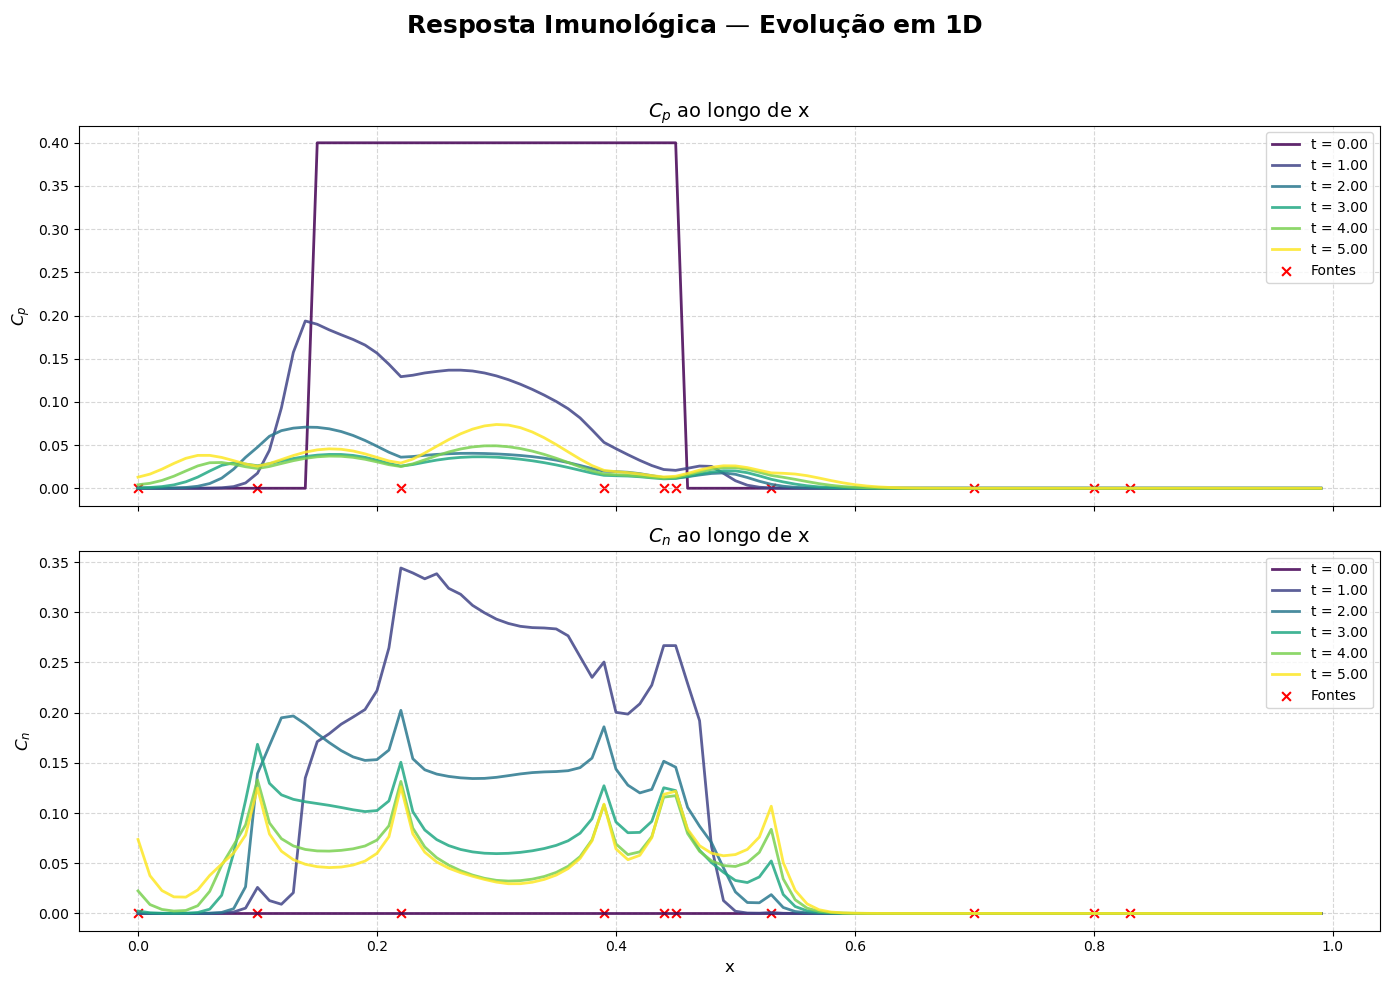

In [34]:
plot_results(size_t,size_x,t_dom,x_dom,Cb,Cn,leu_source_points)

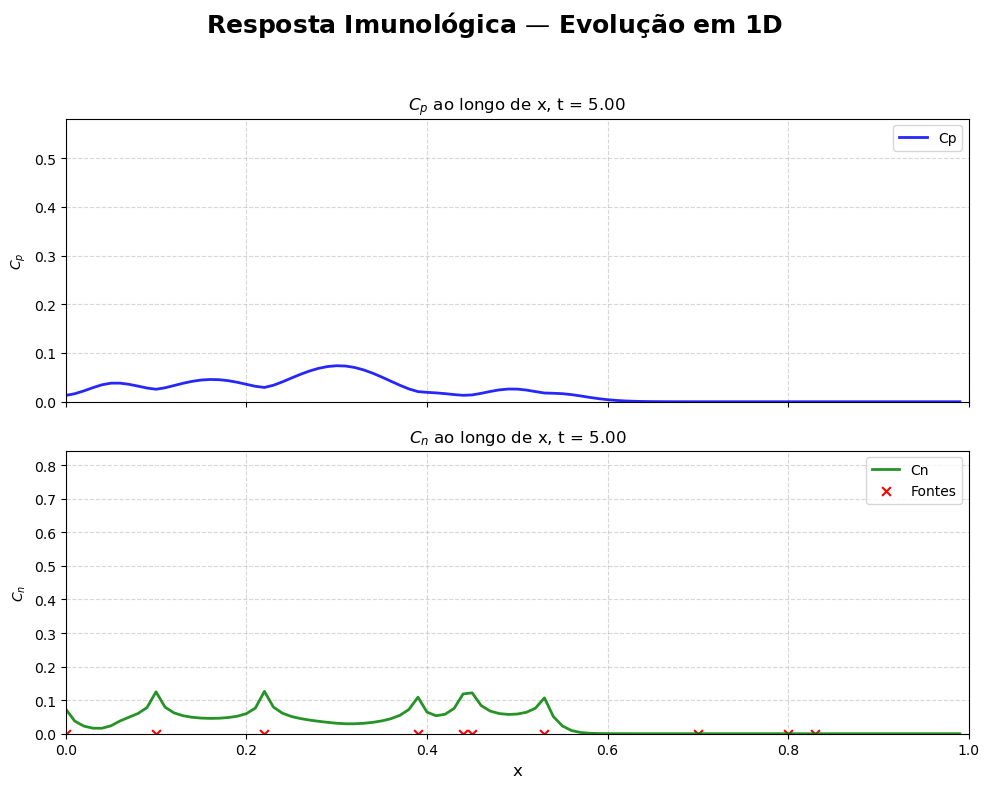

In [35]:
animate_1D_evolution(
    size_t,
    size_x,
    t_dom,
    x_dom,
    Cb,
    Cn,
    leu_source_points,
    (size_t - 1) // 100,
    150,
)

## Fontes de validação

In [ ]:
center = (0, 0)

radius = 0.15

size_x, size_y, size_t, leu_source_points, struct_name = init_mesh(
    x_dom,
    y_dom,
    t_dom,
    h,
    k,
    center,
    radius,
    create_source=True,
    source_type="random",
)

start = time.time()

Cb, Cn = solve_pde(
    leu_source_points,
    size_t,
    size_x,
    size_y,
    h,
    k,
    Db,
    Dn,
    phi,
    cb,
    lambd_nb,
    mi_n,
    lambd_bn,
    y_n,
    Cn_max,
    X_nb,
    central_ini_cond,
    center=center,
    radius=radius,
    verbose=True,
)

end = time.time()

serial_time = end - start

plot_results(size_t, size_x, Cb, Cn, leu_source_points)


In [ ]:
center = (0.2, 0)

radius = 0.15

size_x, size_y, size_t, leu_source_points, struct_name = init_mesh(
    x_dom,
    y_dom,
    t_dom,
    h,
    k,
    center,
    radius,
    create_source=False,
    source_type="random",
)

start = time.time()

Cb, Cn = solve_pde(
    leu_source_points,
    size_t,
    size_x,
    size_y,
    h,
    k,
    Db,
    Dn,
    phi,
    cb,
    lambd_nb,
    mi_n,
    lambd_bn,
    y_n,
    Cn_max,
    X_nb,
    central_ini_cond,
    center=center,
    radius=radius,
    verbose=True,
)

end = time.time()

serial_time = end - start

plot_results(size_t, size_x, Cb, Cn, leu_source_points)


In [ ]:
center = (0.4, 0)

radius = 0.15

size_x, size_y, size_t, leu_source_points, struct_name = init_mesh(
    x_dom,
    y_dom,
    t_dom,
    h,
    k,
    center,
    radius,
    create_source=False,
    source_type="random",
)

start = time.time()

Cb, Cn = solve_pde(
    leu_source_points,
    size_t,
    size_x,
    size_y,
    h,
    k,
    Db,
    Dn,
    phi,
    cb,
    lambd_nb,
    mi_n,
    lambd_bn,
    y_n,
    Cn_max,
    X_nb,
    central_ini_cond,
    center=center,
    radius=radius,
    verbose=True,
)

end = time.time()

serial_time = end - start

plot_results(size_t, size_x, Cb, Cn, leu_source_points)


In [ ]:
center = (0.6, 0)

radius = 0.15

size_x, size_y, size_t, leu_source_points, struct_name = init_mesh(
    x_dom,
    y_dom,
    t_dom,
    h,
    k,
    center,
    radius,
    create_source=False,
    source_type="random",
)

start = time.time()

Cb, Cn = solve_pde(
    leu_source_points,
    size_t,
    size_x,
    size_y,
    h,
    k,
    Db,
    Dn,
    phi,
    cb,
    lambd_nb,
    mi_n,
    lambd_bn,
    y_n,
    Cn_max,
    X_nb,
    central_ini_cond,
    center=center,
    radius=radius,
    verbose=True,
)

end = time.time()

serial_time = end - start

plot_results(size_t, size_x, Cb, Cn, leu_source_points)


In [ ]:
center = (0.8, 0)

radius = 0.15

size_x, size_y, size_t, leu_source_points, struct_name = init_mesh(
    x_dom,
    y_dom,
    t_dom,
    h,
    k,
    center,
    radius,
    create_source=False,
    source_type="random",
)

start = time.time()

Cb, Cn = solve_pde(
    leu_source_points,
    size_t,
    size_x,
    size_y,
    h,
    k,
    Db,
    Dn,
    phi,
    cb,
    lambd_nb,
    mi_n,
    lambd_bn,
    y_n,
    Cn_max,
    X_nb,
    central_ini_cond,
    center=center,
    radius=radius,
    verbose=True,
)

end = time.time()

serial_time = end - start

plot_results(size_t, size_x, Cb, Cn, leu_source_points)


In [ ]:
center = (1, 0)

radius = 0.15

size_x, size_y, size_t, leu_source_points, struct_name = init_mesh(
    x_dom,
    y_dom,
    t_dom,
    h,
    k,
    center,
    radius,
    create_source=False,
    source_type="random",
)

start = time.time()

Cb, Cn = solve_pde(
    leu_source_points,
    size_t,
    size_x,
    size_y,
    h,
    k,
    Db,
    Dn,
    phi,
    cb,
    lambd_nb,
    mi_n,
    lambd_bn,
    y_n,
    Cn_max,
    X_nb,
    central_ini_cond,
    center=center,
    radius=radius,
    verbose=True,
)

end = time.time()

serial_time = end - start

plot_results(size_t, size_x, Cb, Cn, leu_source_points)


# Versão paralela

In [12]:
# Função que descreve a taxa de variação da concentração de bactérias (Cb)
@cuda.jit(device=True, fastmath=True)
def cu_fb(Cb, Cn, i, j, cb, lambd_nb):
    # O crescimento de bactérias é reduzido pela presença de neutrófilos (Cn)
    # por um fator lambd_nb
    return (cb - lambd_nb * Cn[i, j]) * Cb[i, j]


# Função que descreve a taxa de variação da concentração de neutrófilos (Cn)
@cuda.jit(device=True, fastmath=True)
def cu_fn(Cb, Cn, source_points, i, j, y_n, Cn_max, lambd_bn, mi_n):
    # Crescimento dos neutrófilos depende da presença de bactérias (Cb)
    # Também considera uma taxa de decaimento natural (mi_n) e a interação com
    # bactérias (lambd_bn)
    return (
        y_n * Cb[i, j] * (Cn_max - Cn[i, j]) * source_points[i, j]
        - lambd_bn * Cn[i, j] * Cb[i, j]
        - mi_n * Cn[i, j]
    )


# Função para aplicar condições iniciais à concentração de bactérias (Cb)
@cuda.jit(device=True, fastmath=True)
def cu_apply_initial_conditions(ini_cond, Cb, cx, cy, radius, size_x, size_y):
    for i in range(size_x):
        for j in range(size_y):
            # Calculate distance from center to each point
            if (i - cx) ** 2 + (j - cy) ** 2 <= radius**2:
                Cb[i][j] = ini_cond  # Set point inside the circle to 1

    return Cb


# Função principal para resolver as equações diferenciais parciais usando diferenças finitas
@cuda.jit(fastmath=True)
def cu_solve_pde(
    Cb_buf_0,
    Cn_buf_0,
    Cb_buf_1,
    Cn_buf_1,
    Cb_final,
    Cn_final,
    leu_source_points,
    size_t,
    size_x,
    size_y,
    h,
    k,
    Db,
    Dn,
    phi,
    cb,
    lambd_nb,
    mi_n,
    lambd_bn,
    y_n,
    Cn_max,
    X_nb,
    initial_cond,
    center,
    radius,
):

    # Domain position
    i, j = cuda.grid(2)

    # Aplicando condições iniciais para a concentração de bactérias
    cx_real, cy_real = center
    cx_disc = cx_real / h
    cy_disc = cy_real / h
    radius_disc = radius / h

    # Aplicando condições iniciais para a concentração de bactérias
    Cb_buf_0 = cu_apply_initial_conditions(
        initial_cond, Cb_buf_0, cx_disc, cy_disc, radius_disc, size_x, size_y
    )

    # Armazenando as condições iniciais
    Cb_final[0][i, j] = Cb_buf_0[i, j]
    Cn_final[0][i, j] = Cn_buf_0[i, j]

    # Don't continue if our index is outside the domain

    if i >= size_x or j >= size_y:
        return

    # Prepare to do a grid-wide synchronization later

    grid = cuda.cg.this_grid()

    # Loop sobre o tempo
    for time in range(1, size_t):
        # Atualizando as concentrações anteriores (passo temporal anterior)

        if (time % 2) == 0:

            Cn_old = Cn_buf_1
            Cb_old = Cb_buf_1

            Cn_new = Cn_buf_0
            Cb_new = Cb_buf_0

        else:
            Cn_old = Cn_buf_0
            Cb_old = Cb_buf_0

            Cn_new = Cn_buf_1
            Cb_new = Cb_buf_1

        diff_Cb_right = 0 if (i == size_x - 1) else (Cb_old[i + 1, j] - Cb_old[i, j])

        diff_Cb_left = 0 if (i == 0) else (Cb_old[i, j] - Cb_old[i - 1, j])

        diff_Cb_up = 0 if (j == size_y - 1) else (Cb_old[i, j + 1] - Cb_old[i, j])

        diff_Cb_down = 0 if (j == 0) else (Cb_old[i, j] - Cb_old[i, j - 1])

        # Atualizando as concentrações de bactérias
        Cb_new[i][j] = (
            (k * Db)
            / (h * h * phi)
            * (diff_Cb_right - diff_Cb_left + diff_Cb_up - diff_Cb_down)
            + (k / phi) * cu_fb(Cb_old, Cn_old, i, j, cb, lambd_nb)
            + Cb_old[i, j]
        )

        diff_Cn_right = 0 if i == size_x - 1 else ((Cn_old[i + 1, j] - Cn_old[i, j]))

        diff_Cn_left = 0 if i == 0 else ((Cn_old[i, j] - Cn_old[i - 1, j]))

        diff_Cn_up = 0 if j == size_y - 1 else ((Cn_old[i, j + 1] - Cn_old[i, j]))

        diff_Cn_down = 0 if j == 0 else ((Cn_old[i, j] - Cn_old[i, j - 1]))

        adv_right = (
            0
            if i == size_x - 1
            else (
                (Cn_old[i, j] * diff_Cb_right)
                if diff_Cb_right > 0
                else (Cn_old[i + 1, j] * diff_Cb_right)
            )
        )

        adv_left = (
            0
            if i == 0
            else (
                (Cn_old[i, j] * diff_Cb_left)
                if diff_Cb_left < 0
                else (Cn_old[i - 1, j] * diff_Cb_left)
            )
        )

        adv_up = (
            0
            if j == size_y - 1
            else (
                (Cn_old[i, j] * diff_Cb_up)
                if diff_Cb_up > 0
                else (Cn_old[i, j + 1] * diff_Cb_up)
            )
        )

        adv_down = (
            0
            if j == 0
            else (
                (Cn_old[i, j] * diff_Cb_down)
                if diff_Cb_down < 0
                else (Cn_old[i, j - 1] * diff_Cb_down)
            )
        )

        # Atualizando as concentrações de neutrófilos
        Cn_new[i][j] = (
            (k * Dn)
            / (h * h * phi)
            * (diff_Cn_right - diff_Cn_left + diff_Cn_up - diff_Cn_down)
            - (X_nb * k) / (h * h * phi) * (adv_right - adv_left + adv_up - adv_down)
            + (k / phi)
            * cu_fn(
                Cb_old, Cn_old, leu_source_points, i, j, y_n, Cn_max, lambd_bn, mi_n
            )
            + Cn_old[i, j]
        )

        # Armazenando os resultados para o passo de tempo atual
        Cb_final[time][i][j] = Cb_new[i][j]
        Cn_final[time][i][j] = Cn_new[i][j]

        grid.sync()

# Experimental Setup

In [5]:
from fvm_model_serial import solve_pde
from fvm_model_parallel import cu_solve_pde
import numpy as np
import time
import pickle as pk
import json
import math
from utils import init_mesh
from numba import cuda

# Load constant properties from JSON file
with open("control_dicts/constant_properties.json", "r") as openfile:
    constant_properties = json.load(openfile)

# Load mesh properties from JSON file
with open("control_dicts/mesh_properties.json", "r") as openfile:
    mesh_properties = json.load(openfile)


# Extracting constants and parameters
Db = constant_properties["Db"]
Dn = constant_properties["Dn"]
phi = constant_properties["phi"]
cb = constant_properties["cb"]
lambd_nb = constant_properties["lambd_nb"]
mi_n = constant_properties["mi_n"]
lambd_bn = constant_properties["lambd_bn"]
y_n = constant_properties["y_n"]
Cn_max = constant_properties["Cn_max"]
X_nb = constant_properties["X_nb"]
central_ini_cond = constant_properties["central_ini_cond"]

h = mesh_properties["h"]
k = mesh_properties["k"]
x_dom = mesh_properties["x_dom"]
y_dom = mesh_properties["y_dom"]
t_dom = mesh_properties["t_dom"]

timestamp = time.time()

# Generate random initial condition parameters
center = (0.35, 0)
radius = 0.15

# Initialize mesh and related properties
size_x, size_y, size_t, leu_source_points, struct_name = init_mesh(
    x_dom,
    y_dom,
    t_dom,
    h,
    k,
    center,
    radius,
    source_type="random",
    create_source=True,
)

print(f"Mesh initialized for iteration.")

start = time.time()

# Solve PDE for each initial condition in serial mode

Cb, Cn = solve_pde(
    leu_source_points,
    size_t,
    size_x,
    size_y,
    h,
    k,
    Db,
    Dn,
    phi,
    cb,
    lambd_nb,
    mi_n,
    lambd_bn,
    y_n,
    Cn_max,
    X_nb,
    central_ini_cond,
    center=center,
    radius=radius,
    verbose=False,
)

end = time.time()

serial_time = end - start

print(f"Serial computation time for iteration: {serial_time:.6f} seconds.")

# Save results of serial computation
with open(f"fvm_sim/Cp__{struct_name}__{str(timestamp)}.pkl", "wb") as f:
    pk.dump(Cb, f)

with open(f"fvm_sim/Cl__{struct_name}__{str(timestamp)}.pkl", "wb") as f:
    pk.dump(Cn, f)

# Define CUDA threads and blocks
threadsperblock = (size_x, 1)
blockspergrid_x = math.ceil(size_x / threadsperblock[0])
blockspergrid_y = math.ceil(size_y / threadsperblock[1])
blockspergrid = (blockspergrid_x, blockspergrid_y)

start = time.time()

# Compile CUDA executable and solve PDE using CUDA

# Initialize device arrays for concentrations and sources
Cb_buf_0 = cuda.to_device(np.zeros((size_x, size_y)))
Cn_buf_0 = cuda.to_device(np.zeros((size_x, size_y)))
device_leu_source = cuda.to_device(leu_source_points)

# Additional buffers for synchronization
Cb_buf_1 = cuda.device_array_like(Cb_buf_0)
Cn_buf_1 = cuda.device_array_like(Cn_buf_0)

# Arrays to store results for each time step
Cb_final_device = cuda.to_device(np.zeros((size_t, size_x, size_y)))
Cn_final_device = cuda.to_device(np.zeros((size_t, size_x, size_y)))

cu_solve_pde[threadsperblock, blockspergrid](
    Cb_buf_0,
    Cn_buf_0,
    Cb_buf_1,
    Cn_buf_1,
    Cb_final_device,
    Cn_final_device,
    device_leu_source,
    size_t,
    size_x,
    size_y,
    h,
    k,
    Db,
    Dn,
    phi,
    cb,
    lambd_nb,
    mi_n,
    lambd_bn,
    y_n,
    Cn_max,
    X_nb,
    central_ini_cond,
    center,
    radius,
)

# Copy results back to the host
Cb_host = np.empty(shape=Cb_final_device.shape, dtype=Cb_final_device.dtype)
Cb_final_device.copy_to_host(Cb_host)

Cn_host = np.empty(shape=Cn_final_device.shape, dtype=Cn_final_device.dtype)
Cn_final_device.copy_to_host(Cn_host)

end = time.time()

cuda_comp_time = end - start

start = time.time()

# Solve PDE using CUDA and pre-compiled kernel functions

# Initialize device arrays for concentrations and sources
Cb_buf_0 = cuda.to_device(np.zeros((size_x, size_y)))
Cn_buf_0 = cuda.to_device(np.zeros((size_x, size_y)))
device_leu_source = cuda.to_device(leu_source_points)

# Additional buffers for synchronization
Cb_buf_1 = cuda.device_array_like(Cb_buf_0)
Cn_buf_1 = cuda.device_array_like(Cn_buf_0)

# Arrays to store results for each time step
Cb_final_device = cuda.to_device(np.zeros((size_t, size_x, size_y)))
Cn_final_device = cuda.to_device(np.zeros((size_t, size_x, size_y)))

cu_solve_pde[threadsperblock, blockspergrid](
    Cb_buf_0,
    Cn_buf_0,
    Cb_buf_1,
    Cn_buf_1,
    Cb_final_device,
    Cn_final_device,
    device_leu_source,
    size_t,
    size_x,
    size_y,
    h,
    k,
    Db,
    Dn,
    phi,
    cb,
    lambd_nb,
    mi_n,
    lambd_bn,
    y_n,
    Cn_max,
    X_nb,
    central_ini_cond,
    center,
    radius,
)

# Copy results back to the host
Cb_host = np.empty(shape=Cb_final_device.shape, dtype=Cb_final_device.dtype)
Cb_final_device.copy_to_host(Cb_host)

Cn_host = np.empty(shape=Cn_final_device.shape, dtype=Cn_final_device.dtype)
Cn_final_device.copy_to_host(Cn_host)

end = time.time()

cuda_time = end - start

print(
    f"CUDA computation time with compilation for iteration: {cuda_comp_time:.6f} seconds."
)
print(f"CUDA computation time for iteration: {cuda_time:.6f} seconds.")

# Compute speed-up factor and store it
speed_comp_up = serial_time / cuda_comp_time
speed_up = serial_time / cuda_time
print(f"Speed-up with compilation for iteration: {speed_comp_up:.6f}x")
print(f"Speed-up for iteration: {speed_up:.6f}x")

# Save speed-up
with open(
    "fvm_sim/speed_up__" + struct_name + "__" + str(timestamp) + ".pkl", "wb"
) as f:
    pk.dump(
        {
            "speed_comp_up": speed_comp_up,
            "speed_up": speed_up,
            "cuda_comp_time": cuda_comp_time,
            "cuda_time": cuda_time,
            "serial_time": serial_time,
        },
        f,
    )

struct_name:  h--0.01__k--0.005__x_dom_min--0__x_dom_max--1__y_dom_min--__t_dom_min--0__t_dom_max--5__center--(0.35, 0)__radius--0.15
Size x = 100, y = 1 
 
Steps in time = 1001
Steps in space_x = 100
Steps in space_y = 1

Mesh initialized for iteration.
Serial computation time for iteration: 1.785098 seconds.
CUDA computation time with compilation for iteration: 0.019521 seconds.
CUDA computation time for iteration: 0.008746 seconds.
Speed-up with compilation for iteration: 91.446126x
Speed-up for iteration: 204.112180x


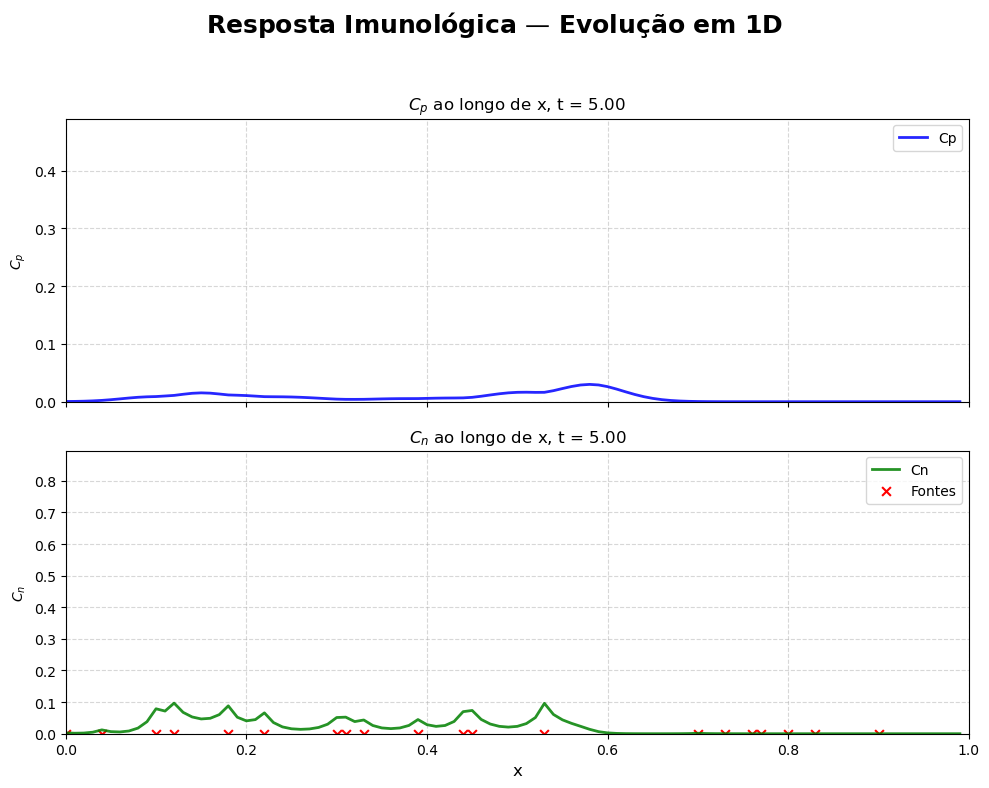

In [6]:
from fvm_animation import animate_1D_evolution

animate_1D_evolution(
    size_t,
    size_x,
    t_dom,
    x_dom,
    Cb,
    Cn,
    leu_source_points,
    (size_t - 1) // 100,
    150,
    name="evolucao_1D__" + str(end),
)

In [4]:
device = cuda.get_current_device()
device.reset()
cuda.close()